## 4. Building a Predictive Model (Pipelining and saving)

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay # want the ones with false neg not positives
from sklearn.metrics import recall_score, precision_score, roc_auc_score, plot_roc_curve, roc_curve, auc, RocCurveDisplay

from matplotlib import pyplot as plt
# import seaborn as sns
from sklearn import set_config # for plotting pipeline

import pickle


In [3]:
# Load data
df = pd.read_csv("data/data.csv") 

# # REMOVE any rows with more than one null for training 
to_drop = df[df.isnull().sum(axis=1) >1].index.tolist()
df = df.drop(to_drop)

# Note this removes 13 rows

In [4]:
# Remove outliers 
def remove_outliers(df, cols):
#     cols = ['Total_Income_log']#, 'LoanAmt_Term_Ratio_Log', 'LoanAmountLog'] 
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
#     df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    df = df[~((df[cols] > (Q3 + 2 * IQR))).any(axis=1)]
    return df

df = remove_outliers(df, ['ApplicantIncome', 'LoanAmount'])
df.shape

(552, 13)

In [5]:
# Separate out target, and drop id column
X = df.drop(columns=['Loan_Status','Loan_ID'])
y = df['Loan_Status'].replace({'Y':1, 'N':0})

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=88)

In [6]:
# Split into cat_feats and num_feats
cat_feats = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']
num_feats = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

def numFeat(data):
    return data[num_feats]

def catFeat(data):
    return data[cat_feats]

keep_num = FunctionTransformer(numFeat)
keep_cat = FunctionTransformer(catFeat)

# Note: Loan amount term is really more categorical, but leaving as numeric so can use in calculations - and will scale
# Credit history will need to be converted to categorical

In [7]:
# Add new columns
def replace_income_with_total_income_log(data):
    data['Total_Income_Log'] = np.log(data['ApplicantIncome'] + data['CoapplicantIncome'])
    data.drop(labels=['ApplicantIncome','CoapplicantIncome'], axis=1, inplace=True)
    return data

def add_LoanAmt_Term_Ratio_Log(data):
    data['LoanAmt_Term_Ratio_Log']=  np.log(data.LoanAmount/data.Loan_Amount_Term)
    return data

def replace_loanamount_with_loanamount_log(X):
    data['LoanAmount_Log'] = np.log(data.LoanAmount)
    data.drop(labels=['LoanAmount'], axis=1, inplace=True)
    return data

# This one works lovely 
def inject_features(data):
    data['Total_Income_Log'] = np.log(data['ApplicantIncome'] + data['CoapplicantIncome'])
    data['LoanAmt_Term_Ratio_Log']=  np.log(data['LoanAmount']/data['Loan_Amount_Term'])
    data['LoanAmount_Log'] = np.log(data['LoanAmount'])
    data.drop(labels=['ApplicantIncome','CoapplicantIncome', 'LoanAmount'], axis=1, inplace=True)
    data.reset_index(inplace=True)
    return data

add_total_income_log_object = FunctionTransformer(replace_income_with_total_income_log)
add_loanamt_term_ratio_log_object = FunctionTransformer(add_LoanAmt_Term_Ratio_Log)
add_loanamount_log_object = FunctionTransformer(replace_loanamount_with_loanamount_log)

injected_features = FunctionTransformer(inject_features)



In [8]:

enc = OneHotEncoder(sparse=False)

pca = PCA(n_components=3)

class ToDenseTransformer():

    # here you define the operation it should perform
    def transform(self, X, y=None, **fit_params):
        return X.todense()

    # just return self
    def fit(self, X, y=None, **fit_params):
        return self
    
to_dense = ToDenseTransformer()


selection = SelectKBest(k=3)



In [9]:
def fill_null(data):
    fill_NaN = SimpleImputer(missing_values=np.nan, strategy='median')
    imputed = pd.DataFrame(fill_NaN.fit_transform(data))
    imputed.columns = data.columns
    imputed.index = data.index
    return imputed

fill_null1 = FunctionTransformer(fill_null)    

In [10]:

numeric_transform = Pipeline([('keep_num', keep_num),
                            ('impute_median', fill_null1),
                            ('injected', injected_features),
                            ('scaling', StandardScaler()),
                            ("kbest", selection)]) 


categorical_transform = Pipeline([('keep_cat', keep_cat),
                                ('impute_mode', SimpleImputer(strategy='most_frequent')), 
                                  ('one-hot-encode', OneHotEncoder(sparse=False)),
                                  #("to_dense", to_dense),
                                 ("pca", pca)])

all_features = FeatureUnion([('numeric_transform', numeric_transform),
                            ('categorical_transform', categorical_transform)])

## Logistic Regression

In [11]:
main_pipeline = Pipeline([('all_features', all_features),
                     ("model", LogisticRegression())])

model = main_pipeline.fit(X_train, y_train)

# new_X_test = X_test.to_numpy().reshape(-1, 1)
# new_X_test
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision =  precision_score(y_test, y_pred, average='micro')

print(f'Test set accuracy: {acc}')
print(f'Test set recall: {recall}')
print(f'Precision: {precision}')


Test set accuracy: 0.7207207207207207
Test set recall: 0.5249208860759493
Precision: 0.7207207207207207


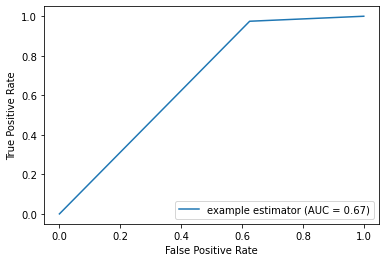

In [92]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()

plt.show()

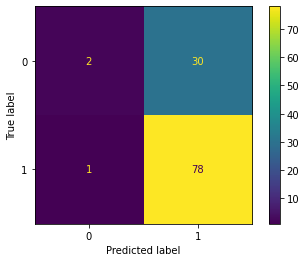

In [12]:
confusion = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp.plot()
plt.show();

In [ ]:
# WITH GRID SEARCH

pipeline = Pipeline(steps = [('all_features', all_features),
                     ("model", LogisticRegression())])

param_grid = {'all_features__categorical_transform__pca__n_components':[3,5,7,8, 9],
              'all_features__numeric_transform__kbest__k': [1,2,3,4]}
              

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_hyperparams = grid_search.best_params_
best_score = grid_search.best_score_

print(f'hyperparameters: {best_hyperparams}\n {best_score}')

# X_test = X_test.dropna()
y_pred = grid_search.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision =  precision_score(y_test, y_pred, average='micro')

print(f'Test set accuracy: {acc}')
print(f'Test set recall: {recall}')
print(f'Precision: {precision}')

In [ ]:
# # Save the model
# with open('deploy/pipeline.pickle', 'wb') as f:
#     pickle.dump(best_model, f)

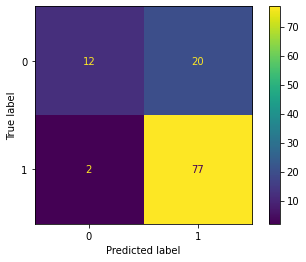

In [89]:
confusion = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp.plot()
plt.show();

In [93]:
from sklearn import set_config
set_config(display='diagram')

pipeline

Pipeline(steps=[('all_features',
                 FeatureUnion(transformer_list=[('numeric_transform',
                                                 Pipeline(steps=[('keep_num',
                                                                  FunctionTransformer(func=<function numFeat at 0x7ff7391e0c10>)),
                                                                 ('impute_median',
                                                                  FunctionTransformer(func=<function fill_null at 0x7ff738717e50>)),
                                                                 ('injected',
                                                                  FunctionTransformer(func=<function inject_features at 0x7ff738717d30>)),
                                                                 ('scaling',
                                                                  StandardScaler()),
                                                                 ('kbest',
                                                                  SelectKBest(k=3))])),
                                                ('categorical_transform',
                                                 Pipeline(steps=[('keep_cat',
                                                                  FunctionTransformer(func=<function catFeat at 0x7ff7391e9160>)),
                                                                 ('impute_mode',
                                                                  SimpleImputer(strategy='most_frequent')),
                                                                 ('one-hot-encode',
                                                                  OneHotEncoder(sparse=False)),
                                                                 ('pca',
                                                                  PCA(n_components=3))]))])),
                ('model', RandomForestClassifier())])

## Random Forest

In [90]:
param_grid = {'all_features__categorical_transform__pca__n_components':[3,5,7,9,11],
              'all_features__numeric_transform__kbest__k': [1,2,3,4],
            'model__n_estimators': [100, 200,300, 500],
              'model__max_depth': [1,2, 3, 7, 10, 20]
             }

pipeline = Pipeline(steps = [('all_features', all_features),
                     ("model", RandomForestClassifier())])
              

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_hyperparams = grid_search.best_params_
best_score = grid_search.best_score_

print(f'hyperparameters: {best_hyperparams}\n {best_score}')


y_pred = grid_search.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision =  precision_score(y_test, y_pred, average='micro')

print(f'Test set accuracy: {acc}')
print(f'Test set recall: {recall}')
print(f'Precision: {precision}')

hyperparameters: {'all_features__categorical_transform__pca__n_components': 9, 'all_features__numeric_transform__kbest__k': 1, 'model__max_depth': 2, 'model__n_estimators': 100}
 0.886972228551176
Test set accuracy: 0.8018018018018018
Test set recall: 0.6748417721518987
Precision: 0.8018018018018018


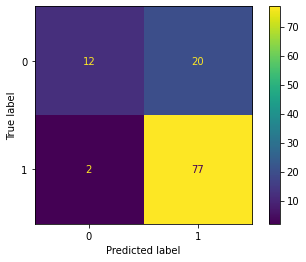

In [91]:
confusion = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp.plot()
plt.show();

In [ ]:
# Save the model
with open('deploy/rf_pipeline.pickle', 'wb') as f:
    pickle.dump(grid_search, f)

## Naive Bayes

In [15]:
pipeline = Pipeline(steps = [('all_features', all_features),
                     ("model",  GaussianNB())])

param_grid = {'all_features__categorical_transform__pca__n_components':[3,5,7,9,11],
              'all_features__numeric_transform__kbest__k': [1,2,3,4],
             }

          
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_hyperparams = grid_search.best_params_
best_score = grid_search.best_score_

print(f'hyperparameters: {best_hyperparams}\n {best_score}')

y_pred = grid_search.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision =  precision_score(y_test, y_pred, average='micro')

print(f'Test set accuracy: {acc}')
print(f'Test set recall: {recall}')
print(f'Precision: {precision}')

hyperparameters: {'all_features__categorical_transform__pca__n_components': 7, 'all_features__numeric_transform__kbest__k': 1}
 0.8723548757064489
Test set accuracy: 0.8108108108108109
Test set recall: 0.7090585443037974
Precision: 0.8108108108108109


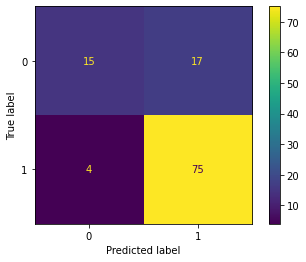

In [16]:
confusion = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp.plot()
plt.show();